---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Credit Card fraud detection

In the current project, we will address the issue of credit card frauds, which is considered to be a form of identity theft. Typically, this type of fraud occurs from the illegal charging of purchases or funds removal from another's account due to unauthorised use of the person's credit card information<sup><a href="https://www.law.cornell.edu/wex/credit_card_fraud">1</a></sup>. This type of fraud is a major cause of concern in financial institutions and fintechs globally. According to the Nilson Report, credit card fraud worldwide led to the loss of $28.58 billion in 2020<sup><a href="https://nilsonreport.com/mention/1515/1link/">2</a></sup>.

<p align=center>
<img src="img/cctheft.jpg" width="50%"><br>
<i><sup>Image credits: kjpargeter (<a href="https://www.freepik.com/search?author=938508&authorSlug=kjpargeter&format=author&selection=1">www.freepik.com</a>)</sup></i>
</p>

Thus, credit card frauds are greatly relevant due to their potential to considerably harm both costumers and financial institutions. Another factor to be taken into account are the action to preventively block a credit card due to suspicious activity. If the transaction is genuine, this causes both stress and embarassment to the clients who are denied their purchase.

For the aforementioned reasons, investments in Fraud Detection through Artificial Inteligence are increasing constantly, presenting as a great Data Science oportunity. Slightly better machine learning algorithms, with great volumes of data as a base, already represent millions in economy through fraud avoidance.

## Getting the data

The data that we are using in this project is available on the [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) website. It consists of anonymized credit card transactions, which were labeled as fraudulent or genuine transactions. 

The dataset actually consists of credit card transactions registered in September 2013 by cardholders in Europe. It represents transactions made over the course of two days, where **492 frauds** were identified, out of 284,807 transactions. In total, the operations marked as fraudulent represent only 0.172% of the total dataset, making this dataset highly unbalanced<sup><a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">3</a></sup>.

<p align=center>
<img src="img/ccpayment.jpg" width="50%"><br>
<i><sup>Image credits: freepik (<a href="https://www.freepik.com/free-photo/person-paying-with-its-credit-card_20083164.htm">www.freepik.com</a>)</sup></i>
</p>

In addition, the source informs that the dataset has been through a dimensionality reduction transformation: the Principal Component Analysis (PCA). This was done to protect user identities and other sensitive features in the dataset, while also reducing its complexity.

With the increase in the number of variables in a given dataset, the difficulty to visualize a multi-dimensional hyperspace also increases. The goal of the PCA is to extract important information from this multi-variate data that are inter-correlated. While each variable is considered a different *dimension*, the PCA extracts the information in the dataset as a set of new variables called **principal components**, reducing the number of *dimensions* from the original dataset. These **principal components** correspond to a linear combination of the original variables and their goal is to encapsulate most of the variation present in the dataset<sup><a href="http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/">4</a></sup>.

In our dataset, the **principal components** correspond to the columns in the dataset: $[V1, V2, V3 \dots, Vn]$.

### Loading necessary packages

In [ ]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from scipy import stats

%matplotlib inline

### Importing the data

For ease of access, since this is a bigger file, we will import it as a direct access link.

In [3]:
file_path = "https://onedrive.live.com/download?cid=A06C4A8AAF3A347B&resid=A06C4A8AAF3A347B%215208&authkey=AAdhamfzp5RS9PM"

# Downloading and reading the file
df = pd.read_csv(file_path)

Now, let's verify basic characteristics of our dataset and subset the `test` data that is going to be used later on.

In [11]:
# Original size
print('Original size of the dataset: ', df.shape[0], ' entries.')

# Separating test data
test = df.sample(frac=0.15, random_state=42)

# Removing test data from regular df
df = df.drop(test.index)

# Test dataset size
print('Test dataset size: ', test.shape[0], ' entries.')
print('Remaining dataset size: ', df.shape[0], ' entries.')

Original size of the dataset:  174907  entries.
Test dataset size:  26236  entries.
Remaining dataset size:  148671  entries.


Having imported the data, we can begin the exploratory analysis of the dataset while also preparing the data to use in a **machine learning** model.

## Exploratory analysis

To begin our analysis, let us look a the first entries of the dataframe:

In [12]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
10,10.0,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,-1.720408,...,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80,0


From this initial look, we can see that our data is entirely numeric after the dimensionality reduction (the *Principal Component Analysis*). Follow [this link](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) if you want to know more about the method.

The only values that were preserved were the columns:
* `Time`: Number of seconds elapsed between this transaction and the first transaction in the dataset;
* `Amount`: Value that represents the transaction amount;
* `Class`: Binary coded variable, with '1' representing fraudulent transactions and '0' representing regular ones.

Now, let us do descriptive statistics on the dataset and check if there are any missing values:

In [16]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,...,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000,148671.000000
mean,94665.917819,0.001213,-0.003787,0.000954,0.000726,-0.000325,0.000314,0.001003,0.001141,0.002966,...,0.002433,-0.000928,-0.000682,0.000927,-0.000814,-0.000461,-0.001375,0.000457,88.940157,0.001762
std,47491.905807,1.952630,1.652412,1.504227,1.412236,1.396980,1.342388,1.243926,1.175264,1.096171,...,0.728833,0.725047,0.628792,0.605060,0.521639,0.483091,0.408883,0.334947,255.996600,0.041943
min,1.000000,-56.407510,-72.715728,-48.325589,-5.401678,-113.743307,-26.160506,-31.197329,-50.943369,-9.481456,...,-22.757540,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.895244,-15.430084,0.000000,0.000000
25%,54063.000000,-0.919470,-0.595982,-0.889173,-0.845732,-0.689837,-0.767787,-0.552822,-0.208169,-0.640412,...,-0.227944,-0.543619,-0.161469,-0.353986,-0.317920,-0.327894,-0.071149,-0.052876,5.600000,0.000000
50%,84637.000000,0.017236,0.064909,0.179942,-0.017119,-0.053146,-0.275032,0.039402,0.022356,-0.048429,...,-0.028440,0.006152,-0.011055,0.041329,0.015947,-0.052161,0.001078,0.011486,22.170000,0.000000
75%,139151.000000,1.315186,0.800026,1.024311,0.744782,0.613433,0.395862,0.569151,0.326845,0.603295,...,0.188001,0.530247,0.147524,0.441170,0.350957,0.240191,0.090842,0.078705,77.500000,0.000000
max,172792.000000,2.451888,16.497472,4.187811,16.715537,34.801666,73.301626,120.589494,18.329406,10.392889,...,27.202839,7.357255,19.228169,4.584549,7.519589,3.415636,31.612198,33.847808,25691.160000,1.000000


In [19]:
# Checking for null values
df.isnull().sum().max()

0

As we can see, we have no columns that contain missing values in our dataset, as indicated above. As for our numeric data, we can already see that we have possible outliers, indicated by min/max values that are distant from the mean or median of the variables. Before checking the outliers, let's see how (un)balanced our dataset is.

0    148409
1       262
Name: Class, dtype: int64

These frauds represent 0.1762% of the dataset.



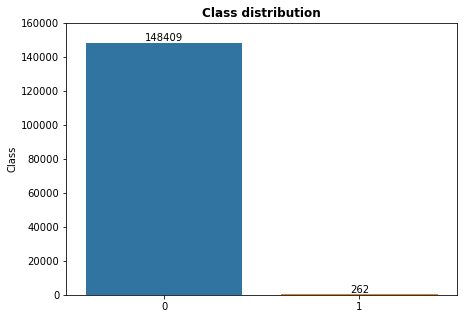

In [48]:
# Count class values
print(df.Class.value_counts())

# How much %? Does it match the number stated by the provider?
print('\nThese frauds represent {:.4f}% of the dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Plotting barplot
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=df.Class.unique(), y=df.Class.value_counts(), data=df, ax=ax)
ax.set_title('Class distribution', fontsize=12, weight='bold')
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.bar_label(ax.containers[0]);



Abordar tópicos/informações como:

* Plotar os seguintes histogramas:
    * Variável `Time`
        * Fraude (`Class == 1`)
        * Normal (`Class == 0`)
    * Variável `Amount`
        * Fraude (`Class == 1`)
        * Normal (`Class == 0`)
* Plotar um `boxplot` para a variável `Amount` quando houve fraude (`Class == 1`)
* Plotar uma matriz de correlação

## Preparação dos Dados

* Normalizar os dados que ainda não haviam sido pré-processados (`Time` e `Amount`)
* Dividir o conjunto de dados entre treino e validação
* [*Recomendado*] Balancear o conjunto de dados

## Modelo de Machine Learning

* Construir um modelo para **classificação**.
* [*Opcional*] Construir mais de um modelo para avaliar os desempenhos

## Avaliar o desempenho do modelo

* Identificar a melhor métrica para esse tipo de modelo
* [*Opcional*] Comparar o desempenho entre diversos modelos

## Conclusão

* Escrever suas conclusões a respeito da construção do modelo